# Predicción de precios de alquileres de Airbnb

Hay 5 variables de precio:
- Price: Precio por noche.
- Weekly Price: Precio por semana.
- Monthly Price: Precio por mes.
- Security Deposit: Depósito.
- Cleaning Fee: Tasa de limpieza.

El objetivo de este proyecto será crear un modelo que prediga la variable 'Price'. El resto de variables relacionadas con el precio no las voy a usar, porque si las usara se produciría [data leakage](https://en.wikipedia.org/wiki/Leakage_(machine_learning)).

Crearé una variable 'log Price', logaritmo del precio, para entrenar los modelos. De esta forma los errores cometidos en los alquileres caros y baratos afectarán de igual medida a la función de coste.

Cargo las librerías:

In [1]:
import pandas as pd
from IPython.display import display
import numpy as np
from sklearn.model_selection import train_test_split
import time

Cargo los datos:

In [2]:
Airbnb = pd.read_csv('airbnb-listings-extract.csv',sep = ';')

In [3]:
Airbnb.head()

,ID,Listing Url,Scrape ID,Last Scraped,Name,Summary,Space,Description,Experiences Offered,Neighborhood Overview,...,Review Scores Communication,Review Scores Location,Review Scores Value,License,Jurisdiction Names,Cancellation Policy,Calculated host listings count,Reviews per Month,Geolocation,Features
0,11210388,https://www.airbnb.com/rooms/11210388,20170306202425,2017-03-07,The Loft-Full Bath-Deck w/View,Loft in the Hill country 12-15 minutes directl...,This loft has a spectacular view of the hills ...,Loft in the Hill country 12-15 minutes directl...,none,This neighborhood is located in the hills west...,...,10.0,10.0,10.0,NaN,NaN,moderate,1.0,3.50,"30.3373609355,-97.8632766782","Host Is Superhost,Host Has Profile Pic,Host Id..."
1,17471131,https://www.airbnb.com/rooms/17471131,20170407214050,2017-04-08,"Claris I, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,10.0,8.0,10.0,HUTB-006721,NaN,super_strict_30,106.0,0.86,"41.3896829422,2.17262543017","Host Has Profile Pic,Requires License,Instant ..."
2,17584891,https://www.airbnb.com/rooms/17584891,20170407214050,2017-04-08,"Style Terrace Red, Friendly Rentals","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...","This apartment has: 1 double bed, 1 double sof...",none,Plaza Cataluña Catalonia Square is the large...,...,NaN,NaN,NaN,HUTB-007527,NaN,super_strict_30,106.0,NaN,"41.3930345489,2.16217327868","Host Has Profile Pic,Requires License,Instant ..."
3,5398030,https://www.airbnb.com/rooms/5398030,20170407214050,2017-04-08,Picasso Suite 1.4 Paseo de Gracia,Live like a local in Barcelona's most chic dis...,You wake up to the sun rising over Barcelona's...,Live like a local in Barcelona's most chic dis...,none,We're right in the heart of the chic L'Eixampl...,...,10.0,10.0,9.0,NaN,NaN,strict,24.0,1.09,"41.3969668101,2.1674178103","Host Has Profile Pic,Host Identity Verified,Re..."
4,18104606,https://www.airbnb.com/rooms/18104606,20170407214050,2017-04-08,Smart City Centre Apartment II,"Unique apartment in vibrant neighborhoods, car...","License: HUTB-005313 Charming apartment, locat...","Unique apartment in vibrant neighborhoods, car...",none,NaN,...,NaN,NaN,NaN,NaN,NaN,flexible,92.0,NaN,"41.3886851936,2.15514963616","Host Has Profile Pic,Host Identity Verified,Is..."


In [4]:
Airbnb.shape

(14780, 89)

Voy a ver cual es el porcentaje de valores faltantes que hay en cada variable:

In [5]:
def Nulos(datos_1):
    
    Nulos = pd.DataFrame(columns=['Variable','Porcentaje de nulos','Cantidad de nulos'])
    observaciones = datos_1.shape[0]

    for columna,n in zip(datos_1.columns,range(len(datos_1.columns))):
        cantidad = sum(datos_1[columna].isna())
        Nulos.loc[n,:]=[columna,100*cantidad/observaciones,cantidad]
    
    pd.set_option('display.max_rows', 100)
    display(Nulos)
    pd.reset_option('display.max_rows')

    return Nulos

In [6]:
A = Nulos(Airbnb)

,Variable,Porcentaje de nulos,Cantidad de nulos
0,ID,0,0
1,Listing Url,0,0
2,Scrape ID,0,0
3,Last Scraped,0,0
4,Name,0.0067659,1
5,Summary,3.99865,591
6,Space,26.3329,3892
7,Description,0.0405954,6
8,Experiences Offered,0,0
9,Neighborhood Overview,38.2003,5646


La variable objetivo es Price, es decir, el precio del alojamiento por noche. En consecuencia, elimino las 17 observaciones para las que falta esta variable.

In [7]:
for n in Airbnb[Airbnb['Price'].isna()].index:
    Airbnb.drop(n, inplace=True)

Airbnb.index = range(Airbnb.shape[0])

In [8]:
Airbnb.shape

(14763, 89)

In [9]:
Nulos = Nulos(Airbnb)

,Variable,Porcentaje de nulos,Cantidad de nulos
0,ID,0,0
1,Listing Url,0,0
2,Scrape ID,0,0
3,Last Scraped,0,0
4,Name,0.00677369,1
5,Summary,3.97616,587
6,Space,26.3293,3887
7,Description,0.0406421,6
8,Experiences Offered,0,0
9,Neighborhood Overview,38.1968,5639


Elimino todas las variables de precio excepto Price, para evitar data leakage: precio por semana (Weekly Price), precio por mes (Monthly Price), deposito (Security Deposit) y tasa de limpieza (Cleaning Fee).

Elimino aquellas variables con muchos valores faltantes. Eliminaré aquellas variables con más de 1/3 de valores faltantes.

In [10]:
límite = 100/3
list_vars_mas_de_1_3 = list(Nulos['Variable'][Nulos['Porcentaje de nulos']>=límite])

Las variables a eliminar son:

In [11]:
list_vars_mas_de_1_3

['Neighborhood Overview',
 'Notes',
 'Transit',
 'Access',
 'Interaction',
 'House Rules',
 'Host About',
 'Host Acceptance Rate',
 'Neighbourhood',
 'Square Feet',
 'Weekly Price',
 'Monthly Price',
 'Security Deposit',
 'Cleaning Fee',
 'Has Availability',
 'License',
 'Jurisdiction Names']

In [12]:
list_vars_menos_de_1_3 = list(Nulos['Variable'][Nulos['Porcentaje de nulos']<límite])
A_3 = Airbnb.loc[:, list_vars_menos_de_1_3]
A_3.columns

Index(['ID', 'Listing Url', 'Scrape ID', 'Last Scraped', 'Name', 'Summary',
       'Space', 'Description', 'Experiences Offered', 'Thumbnail Url',
       'Medium Url', 'Picture Url', 'XL Picture Url', 'Host ID', 'Host URL',
       'Host Name', 'Host Since', 'Host Location', 'Host Response Time',
       'Host Response Rate', 'Host Thumbnail Url', 'Host Picture Url',
       'Host Neighbourhood', 'Host Listings Count',
       'Host Total Listings Count', 'Host Verifications', 'Street',
       'Neighbourhood Cleansed', 'Neighbourhood Group Cleansed', 'City',
       'State', 'Zipcode', 'Market', 'Smart Location', 'Country Code',
       'Country', 'Latitude', 'Longitude', 'Property Type', 'Room Type',
       'Accommodates', 'Bathrooms', 'Bedrooms', 'Beds', 'Bed Type',
       'Amenities', 'Price', 'Guests Included', 'Extra People',
       'Minimum Nights', 'Maximum Nights', 'Calendar Updated',
       'Availability 30', 'Availability 60', 'Availability 90',
       'Availability 365', 'Calendar

Voy a eliminar aquellas variables que no aportan ninguna información sobre el alojamiento (IDs, páginas webs scrapeadas, y cuando fueron scrapeadas):
- ID
- Name
- Listing Url
- Scrape ID
- Last Scraped
- Thumbnail Url
- Medium Url
- Picture Url
- XL Picture Url
- Host ID
- Host URL
- Host Thumbnail Url
- Host Picture Url
- Calendar last Scraped

In [13]:
Variables_no_relevantes = ['ID','Name','Listing Url','Scrape ID','Last Scraped','Thumbnail Url',
                           'Medium Url','Picture Url','XL Picture Url','Host ID','Host URL',
                           'Host Thumbnail Url','Host Picture Url']

In [14]:
variables = []
for v in list_vars_menos_de_1_3:
    if v not in Variables_no_relevantes:
        variables.append(v)
variables

['Summary',
 'Space',
 'Description',
 'Experiences Offered',
 'Host Name',
 'Host Since',
 'Host Location',
 'Host Response Time',
 'Host Response Rate',
 'Host Neighbourhood',
 'Host Listings Count',
 'Host Total Listings Count',
 'Host Verifications',
 'Street',
 'Neighbourhood Cleansed',
 'Neighbourhood Group Cleansed',
 'City',
 'State',
 'Zipcode',
 'Market',
 'Smart Location',
 'Country Code',
 'Country',
 'Latitude',
 'Longitude',
 'Property Type',
 'Room Type',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Bed Type',
 'Amenities',
 'Price',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Calendar Updated',
 'Availability 30',
 'Availability 60',
 'Availability 90',
 'Availability 365',
 'Calendar last Scraped',
 'Number of Reviews',
 'First Review',
 'Last Review',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review S

Copio y pego la lista de variables, y elimino aquellas que no voy a usar. Añado Square Feet, porque aunque tiene muchos outliers, puede ser relevante para aquellas variables para las que existe.

In [15]:
variables =[
 'Host Response Time',
 'Host Response Rate',
 'Host Listings Count',
 'Host Total Listings Count',
 'Host Verifications',
 'Neighbourhood Group Cleansed',
 'State',
 'Market', # Es la zona, a nivel de ciudad.
 'Country Code',
 'Property Type',
 'Room Type',
 'Accommodates',
 'Bathrooms',
 'Bedrooms',
 'Beds',
 'Bed Type',
 'Amenities',
 'Price',
 'Guests Included',
 'Extra People',
 'Minimum Nights',
 'Maximum Nights',
 'Calendar Updated',
 'Availability 30',
 'Availability 60',
 'Availability 90',
 'Availability 365',
 'Number of Reviews',
 'Review Scores Rating',
 'Review Scores Accuracy',
 'Review Scores Cleanliness',
 'Review Scores Checkin',
 'Review Scores Communication',
 'Review Scores Location',
 'Review Scores Value',
 'Cancellation Policy',
 'Calculated host listings count',
 'Reviews per Month',
 'Features',
 'Square Feet']

In [16]:
Datos = Airbnb.loc[:, variables]

In [17]:
print("La variable 'Square Feet' toma valores entre",np.min(Datos['Square Feet']),
      'y',np.max(Datos['Square Feet']))

La variable 'Square Feet' toma valores entre 0.0 y 6997.0


Luego sustituyo el valor NaN de 'Square Feet' por -6997, de tal forma que este claramente diferenciado del resto de valores:

In [18]:
Faltantes = Datos['Square Feet'].isna()

for n in range(Datos.shape[0]):
    
    if Faltantes[n]:
        Datos.at[n,'Square Feet'] = -6997

In [19]:
Datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14763 entries, 0 to 14762
Data columns (total 40 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Host Response Time              12867 non-null  object 
 1   Host Response Rate              12867 non-null  float64
 2   Host Listings Count             14760 non-null  float64
 3   Host Total Listings Count       14760 non-null  float64
 4   Host Verifications              14758 non-null  object 
 5   Neighbourhood Group Cleansed    13751 non-null  object 
 6   State                           14622 non-null  object 
 7   Market                          14706 non-null  object 
 8   Country Code                    14763 non-null  object 
 9   Property Type                   14763 non-null  object 
 10  Room Type                       14763 non-null  object 
 11  Accommodates                    14763 non-null  int64  
 12  Bathrooms                       

## Códificación de variables categóricas:

### Host Response Time

In [20]:
Datos['Host Response Time'].unique()

array(['within an hour', 'within a day', 'within a few hours', nan,
       'a few days or more'], dtype=object)

La transformo en una variable numérica con un valor mayor cuanto mayor sea el tiempo que tarda el casero en responder a las incidencias. El valor nan toma el valor máximo.

In [21]:
for n in range(Datos.shape[0]):
    
    if Datos.at[n,'Host Response Time'] == 'within an hour':
        Datos.at[n,'Host Response Time'] = 1
        
    if Datos.at[n,'Host Response Time'] == 'within a few hours':
        Datos.at[n,'Host Response Time'] = 2
        
    if Datos.at[n,'Host Response Time'] == 'within a day':
        Datos.at[n,'Host Response Time'] = 3
        
    if Datos.at[n,'Host Response Time'] == 'a few days or more':
        Datos.at[n,'Host Response Time'] = 4
        
    else:
        Datos.at[n,'Host Response Time'] = 5

In [22]:
Datos['Host Response Time'].unique()

array([5, 4], dtype=object)

In [23]:
Datos['Host Response Time'] = pd.to_numeric(Datos['Host Response Time'])

### Host Verifications

Incluiré como variable el número de formas que hay de contactar al casero. En el caso de nan, consideraré que hay 0 formas de contactarle.

In [24]:
Datos.at[1,'Host Verifications']

'email,phone,reviews,work_email'

In [25]:
len(Datos.at[1,'Host Verifications'].split(sep=','))

4

In [26]:
Numero_de_verificaciones = []
Faltantes = Datos['Host Verifications'].isna()

for n in range(Datos.shape[0]):
    
    if Faltantes[n]:
        Numero_de_verificaciones.append(0)
    
    else:
        Numero_de_verificaciones.append(len(Datos.at[n,'Host Verifications'].split(sep=',')))

Numero_de_verificaciones[0:20]

[4, 4, 4, 7, 4, 4, 3, 4, 4, 4, 2, 5, 4, 4, 4, 7, 4, 4, 5, 3]

In [27]:
Datos['Host Verifications'] = pd.to_numeric(Numero_de_verificaciones)

## Room Type

In [28]:
Datos['Room Type'].unique()

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

Voy a asignar los números a las 3 categorías, en función de la cantidad de la casa de la que puede disponer el huésped:
- 3, si dispone de toda la casa.
- 2, si dispone de una habitación.
- 1, si dispone de una habitación compartida.

In [29]:
for n in range(Datos.shape[0]):
    
    if Datos.at[n,'Room Type'] == 'Entire home/apt':
        Datos.at[n,'Room Type'] = 3
        
    if Datos.at[n,'Room Type'] == 'Private room':
        Datos.at[n,'Room Type'] = 2
        
    if Datos.at[n,'Room Type'] == 'Shared room':
        Datos.at[n,'Room Type'] = 1
        
Datos['Room Type'] = pd.to_numeric(Datos['Room Type'])

## Calendar Updated

Los valores que puede tomar la variable son:

In [30]:
Datos['Calendar Updated'].unique()

array(['today', '2 weeks ago', 'yesterday', 'a week ago', '7 months ago',
       '4 weeks ago', '5 weeks ago', '2 days ago', '5 days ago',
       '8 months ago', '1 week ago', '3 weeks ago', '4 days ago',
       '2 months ago', '13 months ago', '6 days ago', '6 weeks ago',
       '3 days ago', '6 months ago', '14 months ago', '7 weeks ago',
       '9 months ago', 'never', '4 months ago', '5 months ago',
       '52 months ago', '3 months ago', '12 months ago', '20 months ago',
       '19 months ago', '31 months ago', '24 months ago', '15 months ago',
       '10 months ago', '21 months ago', '17 months ago', '50 months ago',
       '16 months ago', '22 months ago', '11 months ago', '28 months ago',
       '29 months ago', '30 months ago', '18 months ago', '23 months ago',
       '26 months ago', '34 months ago', '51 months ago', '45 months ago',
       '25 months ago', '35 months ago', '33 months ago', '48 months ago',
       '27 months ago', '57 months ago', '58 months ago', '37 months 

Transformo los valores al número de días al que equivalen:

In [31]:
for n in range(Datos.shape[0]):
    
    A = Datos.at[n,'Calendar Updated']
    
    A = A.replace('months ago','30.5')
    A = A.replace('weeks ago','7')
    A = A.replace('days ago','1')
    A = A.replace('yesterday','1 1')
    A = A.replace('today','0 0')
    A = A.replace('a week ago','1 7')
    A = A.replace('1 week ago','1 7')
    A = A.replace('never','100 30.5') # Sustituyo never por un número mayor a todos los demás.
    
    A = A.split()
    A = float(A[0])*float(A[1])
    
    Datos.at[n,'Calendar Updated'] = A

Datos['Calendar Updated'] = pd.to_numeric(Datos['Calendar Updated'])

In [32]:
Datos['Calendar Updated'].head(10)

0     0.0
1     0.0
2     0.0
3     0.0
4     0.0
5    14.0
6     0.0
7     1.0
8     7.0
9     0.0
Name: Calendar Updated, dtype: float64

## Target encoding

Voy a crear una función que sustituya los valores de una variable v, por ejemplo, en el caso de Neighbourhood Group Cleansed, el barrio, por la media de la variable objetivo cuando la variable v toma ese valor.

En el ejemplo anterior, sustituirá el barrio por la media del precio por noche en ese barrio.

Para evitar un sobreajuste, en el caso de que un barrio tenga muy pocos pisos, se les sustituye por la media global, en lugar de la media del barrio.

En el caso de los valores faltantes, se consideraría que forman su "propio barrio" (y, en general, su propio grupo), ya que el hecho de que un valor falte es informativo.

Para evitar generar un problema de sobreajuste no detectable, se realiza la división train test antes de realizar este encoding, y sólo se hace el encoding con los datos de train.

Si después aparecen clases nuevas en test que no estaban en train, asignaré la media global a estas observaciones.

Realizo la división train/test:

In [33]:
variables_predictoras = [variable for variable in Datos.columns if variable != 'Price']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(Datos[variables_predictoras],
                                                    Datos['Price'],
                                                    test_size=0.1,
                                                    # Asigno la fecha de hoy como random_state
                                                    random_state=28052022)

X_train.shape, X_test.shape

((13286, 39), (1477, 39))

In [35]:
X_train3 = pd.DataFrame(np.matrix(X_train), columns = X_train.columns)

In [36]:
y_train_original = pd.DataFrame(np.matrix(y_train))

In [37]:
y_test_original = pd.DataFrame(np.matrix(y_test))

### Creación de la variable 'log Price':

In [38]:
y_train = np.log(y_train)
y_test = np.log(y_test)

### Continuación del Target Encoding:

Emplearé la siguiente función para realizar el target encoding. Los detalles de su funcionamiento están comentados en el siguiente código:

In [39]:
def Media(var_predictora,var_objetivo,minimo):
    
    # Reajusto los índices de var_predictora y de var_objetivo,
    # para facilitar el trabajo posterior con bucles:
    
    var_predictora.index = range(len(var_predictora))
    var_objetivo.index = range(len(var_objetivo))
    
    # Calculo la media global:
    
    Media_global = np.mean(var_objetivo)
    print('Media global =', Media_global,'\n')
    
    # Inicializo el vector en el sustituiré los valores de var_predictora por
    # las medias por grupo, si el grupo tiene un tamaño superior a mínimo.
    # De lo contrario, sustituiré el valor por la media global.
    
    Medias_locales = [Media_global for uno in np.ones(len(var_predictora))]
    
    # Sustituyo los na por la cadena 'Valor Faltante':
    
    Faltantes = var_predictora.isna()
    for n in range(len(var_predictora)):
        if Faltantes[n]:
            var_predictora[n] = 'Valor Faltante'
            
    # Guardaré las medias de cada grupo en el siguiente diccionario:
    
    Diccionario = {}
            
    # Para cada valor de var_predictora:
    
    for valor in var_predictora.unique():
        
        print('Grupo =',valor)
        
        # Grupo es una máscara de var_predictora
        # que vale True si el valor en correspondiente de var_predictora tiene el valor
        # imprimido en la anterior línea de código.
        
        Grupo = var_predictora == [valor for uno in np.ones(len(var_predictora))]
        
        print('Número de elementos:',sum(Grupo))
        
        if sum(Grupo)>=minimo:
            Media_local = np.mean(var_objetivo[Grupo])
            print('Media local =', Media_local)
            
            for n in range(len(var_predictora)):
                if Grupo[n]:
                    Medias_locales[n] = Media_local
        
        else:
            print('Al haber menos de', minimo, 'elementos, se sustituye por la media global.')
            
            Media_local = Media_global
            
        Diccionario[valor] = Media_local
        
        print('\n')
        
    return Medias_locales, Diccionario

Ejemplo de target encoding:

Target encoding de barrios:

1) Compruebo que en un barrio hay suficientes casas como para estimar la media del precio por noche en dicho barrio. Considero que, para ello, hacen falta al menos 50 casas.

2) Sustituyo el valor del barrio por la media del precio por noche en dicho barrio.

3) Si en un barrio no hay suficientes casas para estimar la media, la sustituyo por la media global.

4) Considero que las casas cuyo barrio no aparece "pertenecen al mismo barrio". En otras palabras: considero que los faltantes son informativos.

In [40]:
Ejemplo, D = Media(X_train['Neighbourhood Group Cleansed'],y_train,50)

Media global = 4.01995447555758 

Grupo = Usera
Número de elementos: 130
Media local = 3.4392038033370786


Grupo = Valor Faltante
Número de elementos: 910
Media local = 4.631118631805605


Grupo = Chamberí
Número de elementos: 861
Media local = 4.034104057627751


Grupo = Centro
Número de elementos: 6115
Media local = 4.10468271923841


<ipython-input-39-2cc26c8081f1>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_predictora[n] = 'Valor Faltante'




Grupo = Salamanca
Número de elementos: 797
Media local = 4.130526559684233


Grupo = Tetuán
Número de elementos: 423
Media local = 3.824527489899366


Grupo = Ciudad Lineal
Número de elementos: 269
Media local = 3.607130886710515


Grupo = Sarrià-Sant Gervasi
Número de elementos: 11
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Sants-Montjuïc
Número de elementos: 36
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Moncloa - Aravaca
Número de elementos: 405
Media local = 3.9917705953925116


Grupo = Retiro
Número de elementos: 389
Media local = 3.9730929282745504


Grupo = Manhattan
Número de elementos: 31
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = San Blas - Canillejas
Número de elementos: 112
Media local = 3.4766132092647957


Grupo = Arganzuela
Número de elementos: 717
Media local = 3.661510114248697


Grupo = Latina
Número de elementos: 339
Media local = 3.349364170875853


Grupo = Puente de 

De esta forma, los primeros valores de la variable original serían:

In [41]:
X_train.loc[0:10,'Neighbourhood Group Cleansed']

0              Usera
1     Valor Faltante
2           Chamberí
3             Centro
4          Salamanca
5             Tetuán
6      Ciudad Lineal
7             Centro
8           Chamberí
9             Centro
10            Centro
Name: Neighbourhood Group Cleansed, dtype: object

Que se transformarían en:

In [42]:
Ejemplo[0:11]

[3.4392038033370786,
 4.631118631805605,
 4.034104057627751,
 4.10468271923841,
 4.130526559684233,
 3.824527489899366,
 3.607130886710515,
 4.10468271923841,
 4.034104057627751,
 4.10468271923841,
 4.10468271923841]

Y el diccionario con la biyección de una variable a otra sería:

In [43]:
D

{'Usera': 3.4392038033370786,
 'Valor Faltante': 4.631118631805605,
 'Chamberí': 4.034104057627751,
 'Centro': 4.10468271923841,
 'Salamanca': 4.130526559684233,
 'Tetuán': 3.824527489899366,
 'Ciudad Lineal': 3.607130886710515,
 'Sarrià-Sant Gervasi': 4.01995447555758,
 'Sants-Montjuïc': 4.01995447555758,
 'Moncloa - Aravaca': 3.9917705953925116,
 'Retiro': 3.9730929282745504,
 'Manhattan': 4.01995447555758,
 'San Blas - Canillejas': 3.4766132092647957,
 'Arganzuela': 3.661510114248697,
 'Latina': 3.349364170875853,
 'Puente de Vallecas': 3.427168127961956,
 'Villa de Vallecas': 4.01995447555758,
 'Neukölln': 4.01995447555758,
 'Ciutat Vella': 4.01995447555758,
 'Chamartín': 4.100382649744139,
 'Carabanchel': 3.4048033775784488,
 'Eixample': 4.736633902050805,
 'Gràcia': 4.01995447555758,
 'Moratalaz': 3.4154296701590905,
 'Brooklyn': 4.01995447555758,
 'Hortaleza': 3.7531407878079226,
 'Barajas': 3.796264827775866,
 'Isole': 4.01995447555758,
 'Fuencarral - El Pardo': 3.9222034724577

## Property Type, Bed Type y Cancellation Policy

Ahora voy a emplear esta función para codificar las siguientes variables:

In [44]:
V = ['Property Type','Bed Type','Cancellation Policy']
V

['Property Type', 'Bed Type', 'Cancellation Policy']

Aplicaré el target encoding tanto al conjunto de train como al de test, pero el conjunto de test será transformado con las medias del de train. Es decir, ambos conjuntos sufrirán la misma transformación.

In [47]:
# El siguiente código me permitirá emplear negrita al usar print:

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

# Aplico target encoding a las 3 variables:
    
for v in V:
    print(color.BOLD + "\nCodificación de la variable",v,"\n" + color.END)
    
    # Ejecuto la transformación en el conjunto de train:
    
    codificada,D = Media(X_train[v],y_train,50)
    X_train[v] = pd.to_numeric(codificada)
    
    # Ejecuto la transformación en el conjunto de test,
    # empleando el diccionario que guarda la biyección variable -> variable transformada
    # que he aplicado sobre train:
    
    for n in X_test.index:
        X_test[v][n] = D[X_test[v][n]]
    X_test[v] = pd.to_numeric(X_test[v])


Codificación de la variable Property Type 

Media global = 4.01995447555758 

Grupo = Apartment
Número de elementos: 10752
Media local = 4.0294061423726815


Grupo = House
Número de elementos: 1234
Media local = 4.097147248995084


Grupo = Guest suite
Número de elementos: 3
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Other
Número de elementos: 200
Media local = 3.918493059850892


Grupo = Bed & Breakfast
Número de elementos: 320
Media local = 3.506092298251373


Grupo = Condominium
Número de elementos: 327
Media local = 3.896751070428921


Grupo = Guesthouse
Número de elementos: 34
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Loft
Número de elementos: 277
Media local = 4.187999365676235


Grupo = Serviced apartment
Número de elementos: 12
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Villa
Número de elementos: 16
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Chale

<ipython-input-47-d6b296c4e425>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[v][n] = D[X_test[v][n]]


Grupo = Real Bed
Número de elementos: 12999
Media local = 4.023174518504618


Grupo = Pull-out Sofa
Número de elementos: 231
Media local = 3.906828015257291


Grupo = Airbed
Número de elementos: 3
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Futon
Número de elementos: 36
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = Couch
Número de elementos: 17
Al haber menos de 50 elementos, se sustituye por la media global.



Codificación de la variable Cancellation Policy 

Media global = 4.01995447555758 

Grupo = moderate
Número de elementos: 3846
Media local = 3.9854336839098394


Grupo = flexible
Número de elementos: 4186
Media local = 3.853789117574492


Grupo = strict
Número de elementos: 5146
Media local = 4.170573117609003


Grupo = flexible_new
Número de elementos: 12
Al haber menos de 50 elementos, se sustituye por la media global.


Grupo = super_strict_60
Número de elementos: 29
Al haber menos de 50 elementos, se sustituye po

## Neighbourhood Group Cleansed, Market, State y Country Code

Las variables de localización están repetidas. Comprimo su información en una sóla variable, a la que llamaré 'Zona', de la siguiente forma:

- Si hay suficientes datos, se estima la media según el barrio ('Neighbourhood Group Cleansed').
- Si no hay suficicientes datos para estimar la media según el barrio, se mira si hay suficientes datos para estimar la media según la ciudad/zona ('Market').
- Si no hay suficicientes datos para estimar la media según la ciudad, se mira si hay suficientes datos para estimar la media según la comunidad autónoma, o estado si es en EEUU ('State').
- Si no hay suficicientes datos para estimar la media según la comunidad autónoma, o estado si es en EEUU, se mira si hay suficientes datos para estimar la media según el país ('Country Code').
- Si tampoco hay suficientes datos, se sustituye por la media global, 73.47192533493903.

Para hacer este proceso, voy a modificar la función para el target encoding, de tal forma que aquellos valores que no se puedan sustituir por una media local se sustituyan por un valor distinto a todos los demás, -10.

In [48]:
np.min(y_train),np.max(y_train)

(2.1972245773362196, 6.906754778648554)

Esto lo hago no tener problemas con el redondeo del ordenador al realizar las comparaciones después.

En este caso, no consideraré los valores faltantes como un grupo en sí mismos, si no que los consideraré como que faltan datos para tomar una decisión. Si falta el valor de 'Neighbourhood Group Cleansed', tomaré el de 'Market', si falta el de 'Market' tomaré el de 'State', si falta el de 'State' tomaré el de 'Country Code'.

In [49]:
def Media2(var_predictora,var_objetivo,minimo):
    
    # Reajusto los índices de var_predictora y de var_objetivo,
    # para facilitar el trabajo posterior con bucles:
    
    var_predictora.index = range(len(var_predictora))
    var_objetivo.index = range(len(var_objetivo))
    
    # Calculo la media global:
    
    Media_global = -10
    print('Media global =', Media_global,'\n')
    
    # Inicializo el vector en el sustituiré los valores de var_predictora por
    # las medias por grupo, si el grupo tiene un tamaño superior a mínimo.
    # De lo contrario, sustituiré el valor por la media global.
    
    Medias_locales = [Media_global for uno in np.ones(len(var_predictora))]
    
    # Sustituyo los na por la cadena 'Valor Faltante':
    
    Faltantes = var_predictora.isna()
    for n in range(len(var_predictora)):
        if Faltantes[n]:
            var_predictora[n] = 'Valor Faltante'
            
    # Guardaré las medias de cada grupo en el siguiente diccionario:
    
    Diccionario = {}
            
    # Para cada valor de var_predictora:
    
    for valor in var_predictora.unique():
        
        print('Grupo =',valor)
        
        # Grupo es una máscara de var_predictora
        # que vale True si el valor en correspondiente de var_predictora tiene el valor
        # imprimido en la anterior línea de código.
        
        Grupo = var_predictora == [valor for uno in np.ones(len(var_predictora))]
        
        print('Número de elementos:',sum(Grupo))
        
        if sum(Grupo)>=minimo:
            Media_local = np.mean(var_objetivo[Grupo])
            
            for n in range(len(var_predictora)):
                if Grupo[n]:
                    Medias_locales[n] = Media_local
        
        else:
            print('Al haber menos de', minimo, 'elementos, se sustituye por la media global.')
            
            Media_local = Media_global
            
        if valor == 'Valor Faltante':
            Media_local = -10
            for n in range(len(var_predictora)):
                if Grupo[n]:
                    Medias_locales[n] = -10
                    
        print('Media local =', Media_local)
            
        Diccionario[valor] = Media_local
        
        print('\n')
        
    return Medias_locales, Diccionario

Las variables que tendré en cuenta son las siguientes:

In [50]:
V = ['Neighbourhood Group Cleansed','Market','State','Country Code']

Hay otras variables que indican el area geográfica, pero la información que aportan ya esta incluida en las cuatro que he escojido.

Guardo en un diccionario las biyecciones con las que transformo cada variable, y guardo los 4 diccionarios en la lista Diccionarios:

In [51]:
Diccionarios = []
for v in V:
    print(color.BOLD + "\nCodificación de la variable",v,"\n" + color.END)
    codificada,D = Media2(X_train[v],y_train,50)
    Diccionarios.append(D)
    X_train[v] = pd.to_numeric(codificada)


Codificación de la variable Neighbourhood Group Cleansed 

Media global = -10 

Grupo = Usera
Número de elementos: 130
Media local = 3.4392038033370786


Grupo = Valor Faltante
Número de elementos: 910
Media local = -10


Grupo = Chamberí
Número de elementos: 861
Media local = 4.034104057627751


Grupo = Centro
Número de elementos: 6115
Media local = 4.10468271923841


Grupo = Salamanca
Número de elementos: 797
Media local = 4.130526559684233


Grupo = Tetuán
Número de elementos: 423
Media local = 3.824527489899366


Grupo = Ciudad Lineal
Número de elementos: 269
Media local = 3.607130886710515


Grupo = Sarrià-Sant Gervasi
Número de elementos: 11
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Sants-Montjuïc
Número de elementos: 36
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Moncloa - Aravaca
Número de elementos: 405
Media local = 3.9917705953925116


Grupo = Retiro
Número de elementos: 38

<ipython-input-49-076da0398800>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  var_predictora[n] = 'Valor Faltante'


Media local = 4.515350063287039


Grupo = New York
Número de elementos: 62
Media local = 4.526340735579435


Grupo = Rome
Número de elementos: 51
Media local = 4.288922232497758


Grupo = Berlin
Número de elementos: 38
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Brussels
Número de elementos: 13
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = London
Número de elementos: 129
Media local = 4.283742443187074


Grupo = Montreal
Número de elementos: 4
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Valor Faltante
Número de elementos: 52
Media local = -10


Grupo = Vienna
Número de elementos: 27
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Amsterdam
Número de elementos: 24
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Edinburgh
Número de elementos: 9
Al habe

Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = VIC
Número de elementos: 5
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Salerno Fisciano
Número de elementos: 1
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Vienna
Número de elementos: 6
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Danmark
Número de elementos: 1
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Valencian Community
Número de elementos: 1
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Venezia
Número de elementos: 2
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = Victoria
Número de elementos: 3
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = ON
Número de e

Número de elementos: 6
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = CU
Número de elementos: 1
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = AU
Número de elementos: 36
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = It
Número de elementos: 1
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10


Grupo = HK
Número de elementos: 2
Al haber menos de 50 elementos, se sustituye por la media global.
Media local = -10




Se puede ver que 'Community of Madrid', 'Comunidad de Madrid', 'Madrid', 'MADRID', 'madrid', 'Communauté de Madrid', 'Região Autônoma de Madrid', 'Madrid, Spain', 'España,Madrid', 'Autonome Gemeinschaft Madrid', 'Madrid capital' y 'Madrid España' aparecen como distintos en la variable 'State'.

No es el único caso así. Esto no es un problema, ya que todos estos grupos tienen medias similares, y en aquellos casos en los que hay muy pocos casos como para formar grupo se trata de outliers, que deben ser considerados aparte. Por ejemplo, aquellos pisos catalogados como 'Autonome Gemeinschaft Madrid' probablemente estas orientados a un público alemán, y en consecuencia deben ser considerados aparte, ya que su precio seguramente será distinto al de aquellos pisos dirigidos a otros mercados, aunque estén en la misma ciudad.

Creo una nueva variable, 'Zona', con las especificaciones que he detallado al inicio:

In [52]:
Zona = [1 for uno in np.ones(len(y_train))]

X_train2 = X_train
y_train2 = y_train

X_train2.index = range(len(X_train2))
y_train2.index = range(len(y_train2))

for n in range(len(Zona)):
    if round(X_train2['Neighbourhood Group Cleansed'][n]) == -10:
        if round(X_train2['Market'][n]) == -10:
            if round(X_train2['State'][n]) == -10:
                if round(X_train2['Country Code'][n]) != -10:
                    Zona[n] = X_train2['Country Code'][n]
            else:
                Zona[n] = X_train2['State'][n]
        else:
            Zona[n] = X_train2['Market'][n]
    else:
        Zona[n] = X_train2['Neighbourhood Group Cleansed'][n]

No ha habido ninguna observación que la halla tenido que sustituir por la media global, como se ve en la siguiente línea de código (ya que como aún no había realizado las sustituciones por dicha media, de haber sido necesarias hubiesen quedado -10):

In [53]:
sum(Zona==-10*np.ones(len(Zona)))

0

Añado 'Zona' como variable:

In [54]:
X_train['Zona'] = Zona

Empleo la misma biyección de las variables 'Neighbourhood Group Cleansed','Market','State' y 'Country Code' a una nueva variable 'Zona' sobre X_test. Las medias que empleo son las de X_train, no las de X_test:

In [55]:
Media_global = np.mean(y_train)

# Inicializo la variable 'Zona' de X_test:
Zona = np.ones(len(X_test['Neighbourhood Group Cleansed']))

Media_global = np.mean(y_train)

X_test.index = list(range(0,len(y_test)))

# Sustituyo los valores de 'Zona' empleando la misma biyección que en train:

for n in X_test.index:
    
    if (X_test['Neighbourhood Group Cleansed'][n] in list(Diccionarios[0])):
        if Diccionarios[0][X_test['Neighbourhood Group Cleansed'][n]] != -10:
            Zona[n] = Diccionarios[0][X_test['Neighbourhood Group Cleansed'][n]]
            continue
            
    if (X_test['Market'][n] in list(Diccionarios[1])):
        if Diccionarios[1][X_test['Market'][n]] != -10:
            Zona[n] = Diccionarios[1][X_test['Market'][n]]
            continue
            
    if (X_test['State'][n] in list(Diccionarios[2])):
        if Diccionarios[2][X_test['State'][n]] != -10:
            Zona[n] = Diccionarios[2][X_test['State'][n]]
            continue
            
    if (X_test['Country Code'][n] in list(Diccionarios[3])):
        if Diccionarios[3][X_test['Country Code'][n]] != -10:
            Zona[n] = Diccionarios[3][X_test['Country Code'][n]]
            continue
            
    Zona[n] = Media_global
    
X_test['Zona'] = Zona

Veo que la distribución de la variable 'Zona' es muy similar en X_train y en X_test:

In [56]:
import seaborn as sns

Histograma de 'Zona' en X_train:

<AxesSubplot:xlabel='Zona', ylabel='Count'>

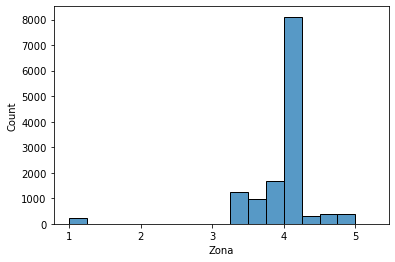

In [57]:
sns.histplot(X_train['Zona'],binwidth=0.25)

Histograma de 'Zona' en X_test:

<AxesSubplot:xlabel='Zona', ylabel='Count'>

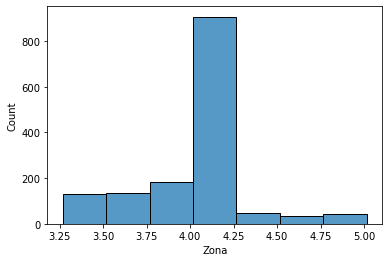

In [58]:
sns.histplot(X_test['Zona'],binwidth=0.25)

Elimino las variables de Neighbourhood Group Cleansed, Market, State y Country Code de X_train y de X_test:

In [59]:
del X_train['Neighbourhood Group Cleansed']
del X_train['Market']
del X_train['State']
del X_train['Country Code']

del X_test['Neighbourhood Group Cleansed']
del X_test['Market']
del X_test['State']
del X_test['Country Code']

## Amenities

La lista de posibles valores en Amenities es:

In [60]:
Lista = []
for n in X_train.index:
    if not pd.isna(X_train['Amenities'][n]):
        valores = X_train['Amenities'][n].split(sep=',')
        for valor in valores:
            Lista.append(valor)
Lista = pd.Series(Lista).unique()
print('Hay',len(Lista),'posibles valores Amenities:')
Lista

Hay 104 posibles valores Amenities:


array(['TV', 'Wireless Internet', 'Kitchen', 'Elevator in building',
       'Heating', 'Family/kid friendly', 'Washer', 'First aid kit',
       'Essentials', 'Shampoo', '24-hour check-in', 'Hangers',
       'Hair dryer', 'Iron', 'translation missing: en.hosting_amenity_50',
       'Internet', 'Air conditioning', 'Smoking allowed', 'Pets allowed',
       'Buzzer/wireless intercom', 'Dryer', 'Laptop friendly workspace',
       'Lock on bedroom door',
       'translation missing: en.hosting_amenity_49',
       'Private living room', 'Cable TV', 'Fire extinguisher',
       'Wheelchair accessible', 'Doorman', 'Suitable for events',
       'Smoke detector', 'Carbon monoxide detector', 'Safety card',
       'Pool', 'Free parking on premises', 'Indoor fireplace',
       'Breakfast', 'Pets live on this property', 'Cat(s)', 'Hot tub',
       'Dog(s)', 'Free parking on street', 'Gym', 'Self Check-In',
       'Doorman Entry', 'Other pet(s)', 'Private entrance',
       'Room-darkening shades', 'Loc

Creo una variable para cada uno de estos elementos, que puede valer 1 o 0 según un piso disponga o no de este elemento:

In [61]:
for Amenitie in Lista:
    Nombre_variable = 'Amenities: ' + Amenitie
    Inicializar_var = []
    for n in X_train.index:
        if not pd.isna(X_train['Amenities'][n]):
            if Amenitie in X_train['Amenities'][n]:
                Inicializar_var.append(1)
            else:
                Inicializar_var.append(0)
        else:
            Inicializar_var.append(0)
    X_train[Nombre_variable] = Inicializar_var

Borro la variable original 'Amenities':

In [62]:
del X_train['Amenities']

In [63]:
X_train.head()

,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,...,Amenities: Patio or balcony,Amenities: Garden or backyard,Amenities: Luggage dropoff allowed,Amenities: Long term stays allowed,Amenities: Path to entrance lit at night,Amenities: Table corner guards,Amenities: Stair gates,Amenities: EV charger,Amenities: BBQ grill,Amenities: Suitable for Events
0,5,100.0,1.0,1.0,3,4.029406,3,6,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,5,NaN,1.0,1.0,3,4.097147,3,5,1.5,3.0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,38.0,38.0,7,4.029406,2,1,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,5,100.0,4.0,4.0,5,4.029406,3,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,1.0,1.0,5,4.029406,2,1,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Repito el procedimiento en X_test, sólo para aquellas Amenities que estaban en X_train:

In [64]:
for Amenitie in Lista:
    Nombre_variable = 'Amenities: ' + Amenitie
    Inicializar_var = []
    for n in X_test.index:
        if not pd.isna(X_test['Amenities'][n]):
            if Amenitie in X_test['Amenities'][n]:
                Inicializar_var.append(1)
            else:
                Inicializar_var.append(0)
        else:
            Inicializar_var.append(0)
    X_test[Nombre_variable] = Inicializar_var
del X_test['Amenities']
X_test.head()

,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,...,Amenities: Patio or balcony,Amenities: Garden or backyard,Amenities: Luggage dropoff allowed,Amenities: Long term stays allowed,Amenities: Path to entrance lit at night,Amenities: Table corner guards,Amenities: Stair gates,Amenities: EV charger,Amenities: BBQ grill,Amenities: Suitable for Events
0,5,100.0,3.0,3.0,6,4.097147,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,5,100.0,1.0,1.0,6,4.029406,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,5,100.0,2.0,2.0,4,4.029406,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,5,100.0,40.0,40.0,4,4.029406,3,6,2.5,3.0,...,0,0,0,0,0,0,0,0,0,0
4,5,100.0,1.0,1.0,7,4.029406,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Features

La lista de posibles Features es:

In [65]:
Lista = []
for n in X_train.index:
    if not pd.isna(X_train['Features'][n]):
        valores = X_train['Features'][n].split(sep=',')
        for valor in valores:
            Lista.append(valor)
Lista = pd.Series(Lista).unique()
print('Hay',len(Lista),'posibles valores Features:')
Lista

Hay 8 posibles valores Features:


array(['Host Has Profile Pic', 'Requires License', 'Is Location Exact',
       'Host Identity Verified', 'Instant Bookable',
       'Require Guest Profile Picture',
       'Require Guest Phone Verification', 'Host Is Superhost'],
      dtype=object)

Repito el mismo procedimiento que realice con 'Amenities' para 'Features', en X_train:

In [66]:
for Feature in Lista:
    Nombre_variable = 'Features: ' + Feature
    Inicializar_var = []
    for n in X_train.index:
        if not pd.isna(X_train['Features'][n]):
            if Amenitie in X_train['Features'][n]:
                Inicializar_var.append(1)
            else:
                Inicializar_var.append(0)
        else:
            Inicializar_var.append(0)
    X_train[Nombre_variable] = Inicializar_var
del X_train['Features']
X_train.head()

,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,...,Amenities: BBQ grill,Amenities: Suitable for Events,Features: Host Has Profile Pic,Features: Requires License,Features: Is Location Exact,Features: Host Identity Verified,Features: Instant Bookable,Features: Require Guest Profile Picture,Features: Require Guest Phone Verification,Features: Host Is Superhost
0,5,100.0,1.0,1.0,3,4.029406,3,6,1.0,3.0,...,0,0,0,0,0,0,0,0,0,0
1,5,NaN,1.0,1.0,3,4.097147,3,5,1.5,3.0,...,0,0,0,0,0,0,0,0,0,0
2,5,NaN,38.0,38.0,7,4.029406,2,1,2.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,5,100.0,4.0,4.0,5,4.029406,3,2,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,5,NaN,1.0,1.0,5,4.029406,2,1,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


Ahora con X_test:

In [67]:
for Feature in Lista:
    Nombre_variable = 'Features: ' + Feature
    Inicializar_var = []
    for n in X_test.index:
        if not pd.isna(X_test['Features'][n]):
            if Amenitie in X_test['Features'][n]:
                Inicializar_var.append(1)
            else:
                Inicializar_var.append(0)
        else:
            Inicializar_var.append(0)
    X_test[Nombre_variable] = Inicializar_var
del X_test['Features']
X_test.head()

,Host Response Time,Host Response Rate,Host Listings Count,Host Total Listings Count,Host Verifications,Property Type,Room Type,Accommodates,Bathrooms,Bedrooms,...,Amenities: BBQ grill,Amenities: Suitable for Events,Features: Host Has Profile Pic,Features: Requires License,Features: Is Location Exact,Features: Host Identity Verified,Features: Instant Bookable,Features: Require Guest Profile Picture,Features: Require Guest Phone Verification,Features: Host Is Superhost
0,5,100.0,3.0,3.0,6,4.097147,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,5,100.0,1.0,1.0,6,4.029406,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2,5,100.0,2.0,2.0,4,4.029406,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,5,100.0,40.0,40.0,4,4.029406,3,6,2.5,3.0,...,0,0,0,0,0,0,0,0,0,0
4,5,100.0,1.0,1.0,7,4.029406,2,1,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Guardar los resultados

Guardo los datasets X_train, y_train, X_test e y_test con las variables codificadas:

In [68]:
#X_train.to_csv('X_train.csv')

#y_train.to_csv('log_y_train.csv')

#y_train_original.to_csv('y_train_original.csv')

#X_test.to_csv('X_test.csv')

#y_test.to_csv('log_y_test.csv')

#y_test_original.to_csv('y_test_original.csv')